# A Deep Dive into Fake news

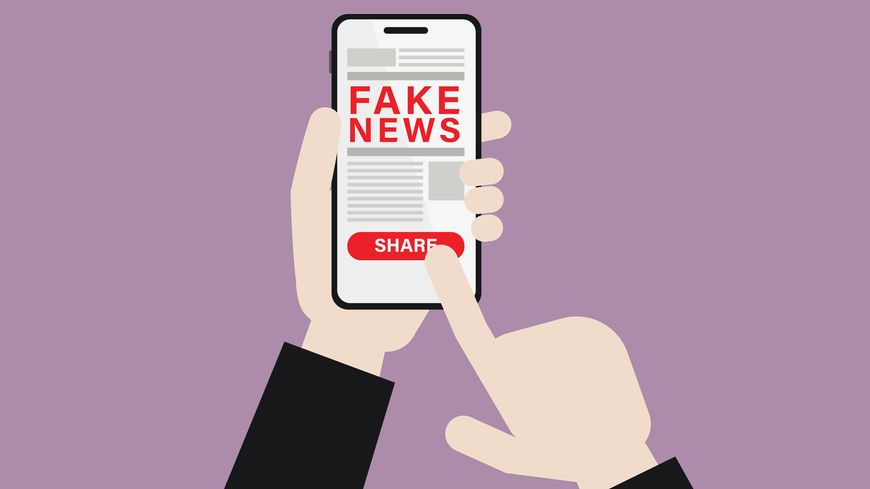

Introduction and research question goes here!!!

## Imports

In [1]:
RANDOM_SEED = 1234

# Basic imports
from pathlib import Path
import re
import pandas as pd
import numpy as np; np.random.seed(RANDOM_SEED)

# Off the shell libraries
import nltk
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import eli5
nltk.download('vader_lexicon')

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns


# Basic path
data_path = Path().resolve().parent / 'data'

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\juans\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## Data Adquisition & preprocessing

Initially, scraping techniques were considered to build our own dataset containing different sources of news articles to compare to their fake equivalents. However, this process became quite time consuming and complex as each web page has its own layout. Hence, a custom scraping script using BeautifulSoup and Selenium should be created. However, [Insert reference of WELFake_dataset] constructed a dataset with more than 72,000 articles from different sources (BBC,)

In [2]:
df = pd.read_csv(data_path/'WELFake_Dataset.csv', index_col=[0]).replace('', np.nan)
# Standardizing text to lower case
df.title = df.title.str.strip().str.lower()
df.text = df.text.str.strip().str.lower()
print(f'There are {len(df)} articles.')
df.head()

There are 72134 articles.


,title,text,label
0,law enforcement on high alert following threat...,no comment is expected from barack obama membe...,1
1,NaN,did they post their votes for hillary already?,1
2,unbelievable! obama’s attorney general says mo...,"now, most of the demonstrators gathered last n...",1
3,"bobby jindal, raised hindu, uses story of chri...",a dozen politically active pastors came here f...,0
4,satan 2: russia unvelis an image of its terrif...,"the rs-28 sarmat missile, dubbed satan 2, will...",1


As the dataset is quite big for the purpose of study, splitting it to work only with news articles that come from Reuters is a nice idea. Also, it is important to check for NAs and a good length of the article to have some meaning.

<AxesSubplot:>

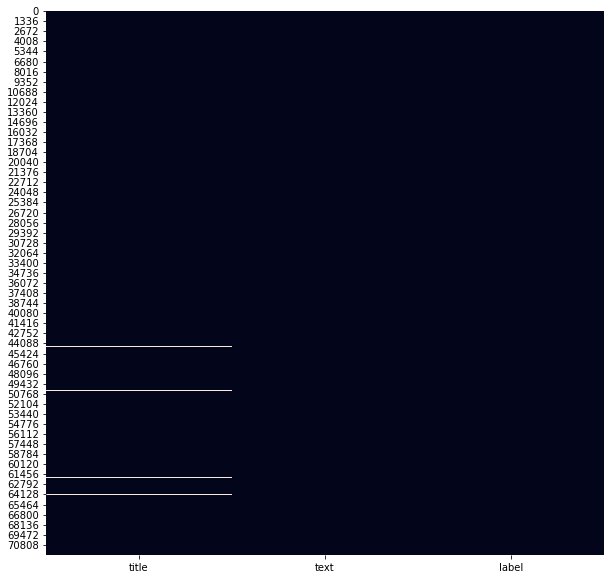

In [3]:
#Checking Nulls
plt.figure(figsize=(10, 10))
sns.heatmap(df.isnull(),cbar=False)

There are 71537 articles after NA analysis.


<AxesSubplot:>

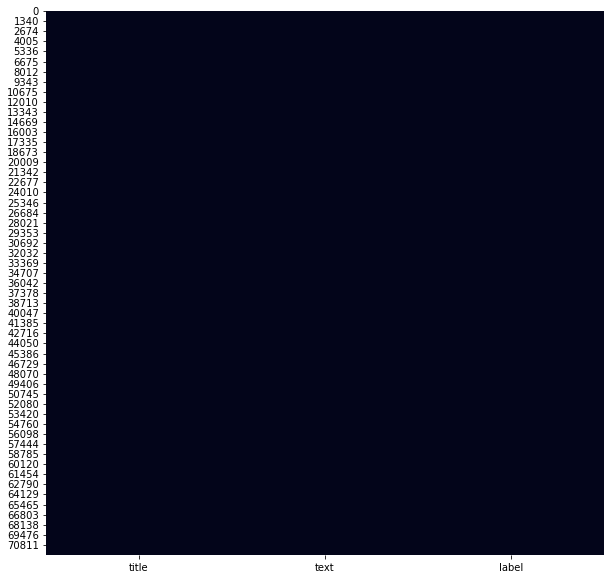

In [4]:
#Remove NaN in column text
df = df.dropna()
print(f'There are {len(df)} articles after NA analysis.')
plt.figure(figsize=(10, 10))
sns.heatmap(df.isnull(),cbar=False)

In [5]:
df_reuters = df[df.text.str.contains("(reuters)")].reset_index(drop= True)
print(f'There are {len(df_reuters)} articles.')
df_reuters.head()

C:\Users\juans\AppData\Local\Temp\ipykernel_16644\3014720590.py:1: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  df_reuters = df[df.text.str.contains("(reuters)")].reset_index(drop= True)


There are 22297 articles.


,title,text,label
0,"may brexit offer would hurt, cost eu citizens ...",brussels (reuters) - british prime minister th...,0
1,schumer calls on trump to appoint official to ...,"washington (reuters) - charles schumer, the to...",0
2,billionaire odebrecht in brazil scandal releas...,rio de janeiro/sao paulo (reuters) - billionai...,0
3,u.n. seeks humanitarian pause in sanaa where s...,geneva (reuters) - the united nations called o...,0
4,second judge says clinton email setup may have...,new york (reuters) - a second federal judge ha...,0


We end up working with almost 22.3K articles from Reuters. Up next, we extract the location of such articles just to add extra info to our analysis. This is also helpful to remove cities for topic analysis

In [6]:
df_reuters['location'] = df_reuters['text'].str.extract(r'^(.+)(?=(\(reuters\)))')[0]
df_reuters.head()

,title,text,label,location
0,"may brexit offer would hurt, cost eu citizens ...",brussels (reuters) - british prime minister th...,0,brussels
1,schumer calls on trump to appoint official to ...,"washington (reuters) - charles schumer, the to...",0,washington
2,billionaire odebrecht in brazil scandal releas...,rio de janeiro/sao paulo (reuters) - billionai...,0,rio de janeiro/sao paulo
3,u.n. seeks humanitarian pause in sanaa where s...,geneva (reuters) - the united nations called o...,0,geneva
4,second judge says clinton email setup may have...,new york (reuters) - a second federal judge ha...,0,new york


As the original dataset is too big for uploading on GitHub, we then save a new one containing only the Reuters articles. This is done to accelerate further analysis.

In [87]:
df_reuters.to_csv(data_path/'WELFake_Reuters_data.csv')

## Descriptive analysis

## Sentiment Analysis - Of the shell library

As we are dealing with a large dataset, it was important to check overall sentiment of the articles in a fast way. That way, it should be interesting to check wether sentimente varies between fake news and real ones. Vader was the off the shell library to use as 

In [8]:
from datetime import datetime
time = datetime.now().strftime("%H:%M:%S")
sent_analyzer = SentimentIntensityAnalyzer()
text_corpus = df_reuters.text.to_list()
predictions = []
print(f'Initializign predictions - {time}')
for idx,article in enumerate(text_corpus):
    time = datetime.now().strftime("%H:%M:%S")
    print(f"\rModel working in article {idx} at {time}", end="") 
    score = sent_analyzer.polarity_scores(article)
    result = {
        'score': score['compound'],
        'likelihood': 'pos' if score['compound'] > 0 else 'neg'
    }

    predictions.append(result)
print(f'\nPrediction complete at {time}.')

Initializign predictions - 11:31:35
Model working in article 22296 at 11:32:53
Prediction complete at 11:32:53.


In [9]:
df_pred = pd.DataFrame(predictions)
df_pred.head()

,score,likelihood
0,-0.8757,neg
1,-0.9020,neg
2,-0.9638,neg
3,0.0000,neg
4,-0.9917,neg


In [10]:
df_sent = df_reuters.join(df_pred)
df_sent.head()

,title,text,label,location,score,likelihood
0,"may brexit offer would hurt, cost eu citizens ...",brussels (reuters) - british prime minister th...,0,brussels,-0.8757,neg
1,schumer calls on trump to appoint official to ...,"washington (reuters) - charles schumer, the to...",0,washington,-0.9020,neg
2,billionaire odebrecht in brazil scandal releas...,rio de janeiro/sao paulo (reuters) - billionai...,0,rio de janeiro/sao paulo,-0.9638,neg
3,u.n. seeks humanitarian pause in sanaa where s...,geneva (reuters) - the united nations called o...,0,geneva,0.0000,neg
4,second judge says clinton email setup may have...,new york (reuters) - a second federal judge ha...,0,new york,-0.9917,neg


## Sentiment analysis - Own approach

After some preprocessing of the dataset, we then start

In [11]:
df_reuters.label.value_counts()

0    21643
1      654
Name: label, dtype: int64

## Topic Classification - LDA

## Building a mode - Is the article fake or not?